In [1]:
import pandas as pd
import numpy as np

## EDA and Preparation

In [2]:
data = pd.read_csv('Data/Datasets/ab_data.csv')

In [3]:
data.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
data.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [9]:
data.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

In [7]:
data[(data.group == 'control') & (data.landing_page != 'old_page')]

,user_id,timestamp,group,landing_page,converted
22,767017,2017-01-12 22:58:14.991443,control,new_page,0
240,733976,2017-01-11 15:11:16.407599,control,new_page,0
490,808613,2017-01-10 21:44:01.292755,control,new_page,0
846,637639,2017-01-11 23:09:52.682329,control,new_page,1
850,793580,2017-01-08 03:25:33.723712,control,new_page,1
...,...,...,...,...,...
293894,741581,2017-01-09 20:49:03.391764,control,new_page,0
293996,942612,2017-01-08 13:52:28.182648,control,new_page,0
294200,928506,2017-01-13 21:32:10.491309,control,new_page,0
294253,886135,2017-01-06 12:49:20.509403,control,new_page,0


In [8]:
data[(data.group == 'treatment') & (data.landing_page != 'new_page')]

,user_id,timestamp,group,landing_page,converted
308,857184,2017-01-20 07:34:59.832626,treatment,old_page,0
327,686623,2017-01-09 14:26:40.734775,treatment,old_page,0
357,856078,2017-01-12 12:29:30.354835,treatment,old_page,0
685,666385,2017-01-23 08:11:54.823806,treatment,old_page,0
713,748761,2017-01-10 15:47:44.445196,treatment,old_page,0
...,...,...,...,...,...
293773,688144,2017-01-16 20:34:50.450528,treatment,old_page,1
293817,876037,2017-01-17 16:15:08.957152,treatment,old_page,1
293917,738357,2017-01-05 15:37:55.729133,treatment,old_page,0
294014,813406,2017-01-09 06:25:33.223301,treatment,old_page,0


Since there are some false values in dataset I will discard them in AB testing

In [10]:
treatment = data.query('group == "treatment" and landing_page == "new_page"')
control = data.query('group == "control" and landing_page == "old_page"')
display(treatment.shape,
        control.shape)

(145311, 5)

(145274, 5)

In [11]:
treatment['converted'].mean()

0.11880724790277405

In [12]:
control['converted'].mean()

0.1203863045004612

In [13]:
consistent_data = treatment.merge(control, how='outer')
consistent_data.shape

(290585, 5)

In [14]:
consistent_data.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

In [22]:
consistent_data['user_id'].duplicated().sum()

1

In [26]:
consistent_data[consistent_data.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
1404,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [27]:
consistent_data[consistent_data.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
938,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
1404,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [28]:
consistent_data.drop(1404, axis='index', inplace=True)

In [29]:
consistent_data.nunique()

user_id         290584
timestamp       290584
group                2
landing_page         2
converted            2
dtype: int64

In [30]:
consistent_data.converted.mean()

0.11959708724499628

## AB Test

There we have ***consistent_data*** on which we will perform AB Testing.  
There are two groups: **treatment** and **control** that differ only in the landing page shown to them.    
We want to check if this difference in landing page has any effect on conversion rate of customers.( Is there any statistically significant difference between converstion rates of these groups? )



In [36]:
consistent_data.converted.mean()

0.11959708724499628

This means 11.95% of visitors converted to customers( regardless of shown landing page)

In [38]:
control.converted.mean()

0.1203863045004612

This means 12.03% of visitors of old landing page bought the item. 

In [39]:
treatment.converted.mean()

0.11880724790277405

This shows that 11.88% of visitors of new landing page converted to customers.

In [40]:
11.88 - 12.03

-0.14999999999999858

As we can see new landing page has 0.15% **less** conversion rate than old one.  
Let's see if this differnce is significant or simply due to chance.

In [55]:
random_treatment = np.random.binomial(n=len(treatment),
                                      p=consistent_data.converted.mean(),
                                      size=100000) / len(treatment)
random_control = np.random.binomial(n=len(control),
                                    p=consistent_data.converted.mean(),
                                    size=100000) / len(control)
random_difference = random_treatment - random_control

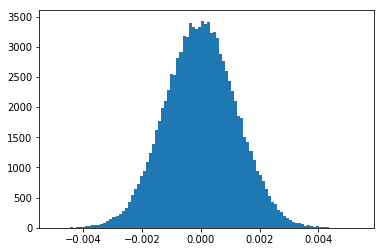

In [56]:
import matplotlib.pyplot as plt

plt.hist(random_difference, bins=100)
plt.show()

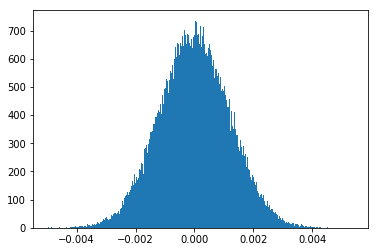

In [57]:
plt.hist(random_difference, bins=500)
plt.show()

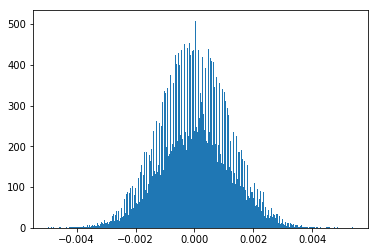

In [58]:
plt.hist(random_difference, bins=1000)
plt.show()

In [59]:
ab_difference = treatment.converted.mean() - control.converted.mean()
ab_difference

-0.0015790565976871451

In [60]:
(random_difference < ab_difference).mean() * 100

9.35

In [61]:
i = 1000000
p_values = list()
count = 0
for j in range(100):
    random_treatment = np.random.binomial(n=len(treatment),
                                          p=consistent_data.converted.mean(),
                                          size=i) / len(treatment)
    random_control = np.random.binomial(n=len(control),
                                        p=consistent_data.converted.mean(),
                                        size=i) / len(control)
    random_difference = random_treatment - random_control

    p_value = (random_difference < ab_difference).mean() * 100
    p_values.append(p_value)
    if p_value < 5:
        print('yes')
        count += 1

In [62]:
p_values

[9.5722,
 9.482899999999999,
 9.4334,
 9.4468,
 9.4756,
 9.4905,
 9.4872,
 9.41,
 9.4856,
 9.4627,
 9.501999999999999,
 9.5083,
 9.4838,
 9.504,
 9.4658,
 9.4848,
 9.5274,
 9.476999999999999,
 9.4603,
 9.5344,
 9.4863,
 9.4885,
 9.5184,
 9.4707,
 9.4874,
 9.4474,
 9.4985,
 9.464599999999999,
 9.4657,
 9.4834,
 9.4932,
 9.4897,
 9.4527,
 9.463199999999999,
 9.464,
 9.4557,
 9.5016,
 9.464699999999999,
 9.5809,
 9.4704,
 9.442599999999999,
 9.4389,
 9.5259,
 9.4888,
 9.4666,
 9.5085,
 9.4487,
 9.4895,
 9.5266,
 9.4315,
 9.5152,
 9.4045,
 9.4962,
 9.5143,
 9.5161,
 9.481100000000001,
 9.4867,
 9.459299999999999,
 9.494900000000001,
 9.485399999999998,
 9.447600000000001,
 9.4901,
 9.504700000000001,
 9.4571,
 9.5317,
 9.497800000000002,
 9.533,
 9.5054,
 9.4467,
 9.487,
 9.4664,
 9.522,
 9.465300000000001,
 9.4794,
 9.4699,
 9.474200000000002,
 9.4694,
 9.4609,
 9.4281,
 9.474499999999999,
 9.525699999999999,
 9.510200000000001,
 9.437800000000001,
 9.4708,
 9.3913,
 9.4995,
 9.4903,
 9.4

Since p_value is not less than 5% null hypothesis can't be rejected.  
We can not claim that new page has less conversion rate than older one.

## Two Sample T-Test

In [64]:
control.converted.describe()

count    145274.000000
mean          0.120386
std           0.325414
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: converted, dtype: float64

In [65]:
treatment.converted.describe()

count    145311.000000
mean          0.118807
std           0.323563
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: converted, dtype: float64

To perform t-test we assume:  
    1. two samples are independent
    2. two groups follow normal distribution
    3. variances of two groups are similar

### Scipy Implementation

H0: means are equal  
HA: means are different

In [66]:
from scipy.stats import ttest_ind

ttest_ind(treatment.converted, control.converted, equal_var=True)

Ttest_indResult(statistic=-1.3116069027036805, pvalue=0.18965383906859376)

since pvalue is greater than 0.05 null hypothesis can not be rejected

### Statsmodels Implementation

In [70]:
from statsmodels.stats.weightstats import ttest_ind
tstat, pvalue, df = ttest_ind(treatment.converted, control.converted)

In [71]:
pvalue

0.18965383906859506

The null hypothesis can not be rejected as the pvalue is higher than 0.05